# Imports

In [212]:
# handle math and data
import numpy as np
import pandas as pd
import time
import math

# to plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# handle files
import os
import sys
import joblib

# output
import tqdm

# deep learning
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

# Setup

In [2]:
SEED = 69

K = keras.backend

def reset_backend():
    K.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Load Data

In [34]:
train_set_raw, valid_set_raw, test_set_raw = tfds.load("mnist", 
                                                       split=["train[:55000]", "train[55000:]", "test"], 
                                                       as_supervised=True)

In [245]:
def preprocess(image, label):
    scaled_image = image / 255
    final_image = tf.cast(scaled_image, tf.float32)
    label_uint8 = tf.cast(label, tf.uint8)
    return final_image, label_uint8

In [45]:
batch_size = 32
train_set = train_set_raw.shuffle(55000).map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [52]:
for images, labels in train_set.take(1):
    sample_batch_images = tf.identity(images)
    sample_batch_labels = tf.identity(labels)

In [88]:
def plot_images(batch, n_rows=4, n_cols=10, n_images=1):
    """Takes a 4D tensor batch of example shape (32, 28, 28, 1) and plots the images."""
    
    plt.figure(figsize=(min(n_cols * 4, 18), 
                        n_rows * 4))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            if index >= n_images:
                plt.show()
                return
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(batch[index], cmap="binary")
            ax = plt.gca()
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
    plt.show()

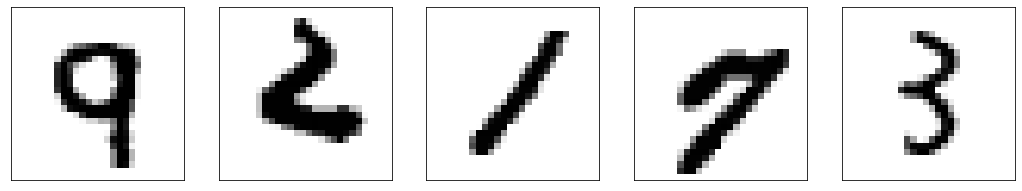

In [91]:
plot_images(sample_batch_images, n_rows=1, n_cols=5, n_images=5)

# Baseline CNN

In [136]:
TENSORBOARD_DIR = os.path.join(".", "_tf_logs", "13_cnn")
os.makedirs(TENSORBOARD_DIR, exist_ok=True)

In [139]:
reset_backend()

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

run_index = 1
run_logdir = os.path.join(TENSORBOARD_DIR, "first_model_run_{:02d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

model.fit(train_set, epochs=10, 
          validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/10
1719/1719 [==============================] - 89s 51ms/step - loss: 0.1873 - accuracy: 0.9429 - val_loss: 0.0525 - val_accuracy: 0.9836
Epoch 2/10
1719/1719 [==============================] - 91s 53ms/step - loss: 0.0797 - accuracy: 0.9762 - val_loss: 0.0427 - val_accuracy: 0.9862
Epoch 3/10
1719/1719 [==============================] - 78s 45ms/step - loss: 0.0593 - accuracy: 0.9822 - val_loss: 0.0366 - val_accuracy: 0.9880
Epoch 4/10
1719/1719 [==============================] - 77s 45ms/step - loss: 0.0516 - accuracy: 0.9843 - val_loss: 0.0332 - val_accuracy: 0.9890
Epoch 5/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.0410 - accuracy: 0.9873 - val_loss: 0.0275 - val_accuracy: 0.9914
Epoch 6/10
1719/1719 [==============================] - 89s 52ms/step - loss: 0.0370 - accuracy: 0.9891 - val_loss: 0.0349 - val_accuracy: 0.9890
Epoch 7/10
1719/1719 [==============================] - 86s 50ms/step - loss: 0.0327 - accuracy: 0.9901 - val_loss: 0.0304 -

In [140]:
model.evaluate(test_set)

313/313 [==============================] - 3s 8ms/step - loss: 0.0321 - accuracy: 0.9921


[0.03214554488658905, 0.9921000003814697]

# Augment Data

- Random adjust brightness
- Random crop
- Random rotation

Let's grab a sample digit to experiment with.

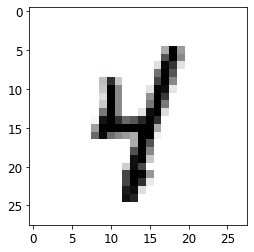

In [143]:
sample_image, sample_label = next(iter(train_set_raw))
plt.imshow(sample_image, cmap="binary")

Let's make a function to compare transformations with original image.

In [144]:
def visualize_transformation(original_image, transformed_image):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original_image, cmap="binary")
    
    plt.subplot(1, 2, 2)
    plt.title("Transformed")
    plt.imshow(transformed_image, cmap="binary")

**Brightness**

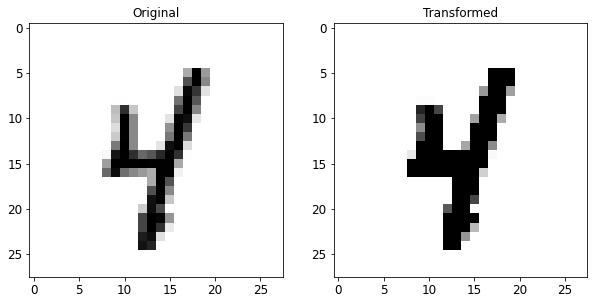

In [182]:
visualize_transformation(sample_image, 
                         tf.image.adjust_brightness(sample_image, 0.7))

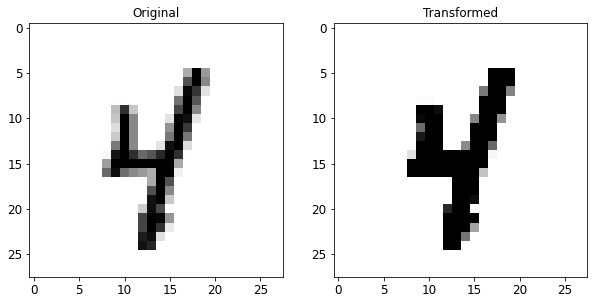

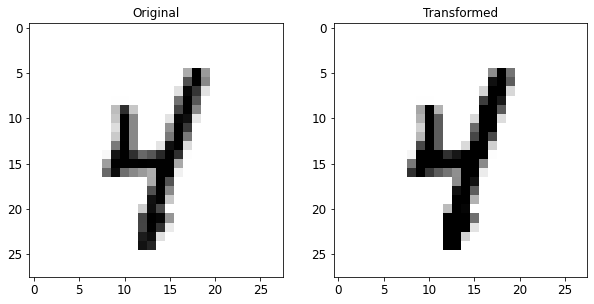

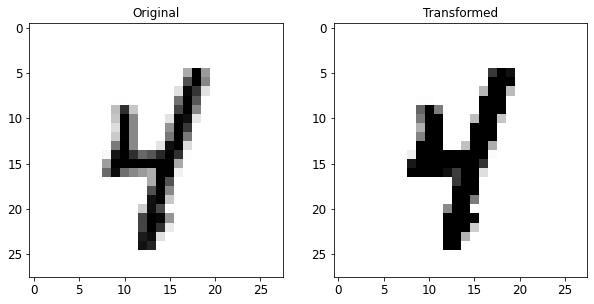

In [194]:
for i in range(3):
    delta = tf.random.uniform([], minval=0.1, maxval=0.9)
    random_brightness = tf.image.adjust_brightness(sample_image, delta)
    visualize_transformation(sample_image, random_brightness)

**Zoom**

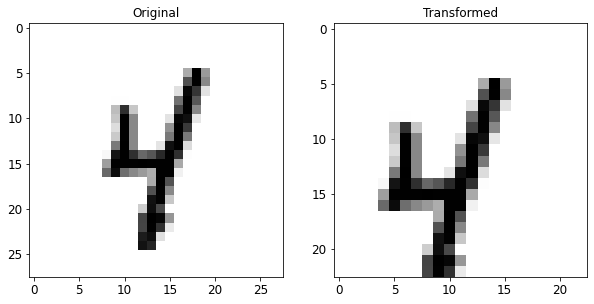

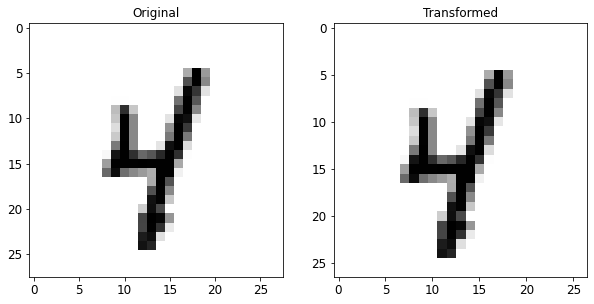

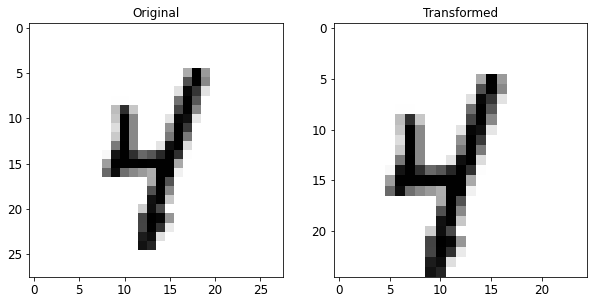

In [210]:
for i in range(3):
    zoom = tf.random.uniform([], minval=1, maxval=1.2).numpy()
    zoomed_size = int(28 / zoom)
    random_crop = tf.image.random_crop(sample_image, size=[zoomed_size, zoomed_size, 1])
    visualize_transformation(sample_image, random_crop)

**Rotation**

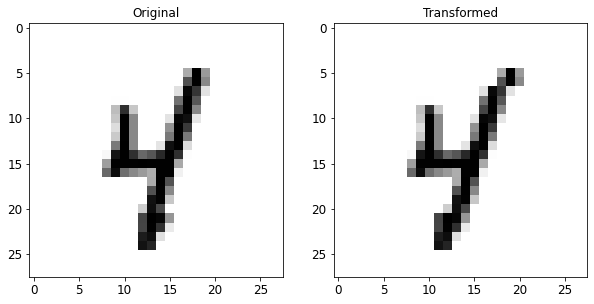

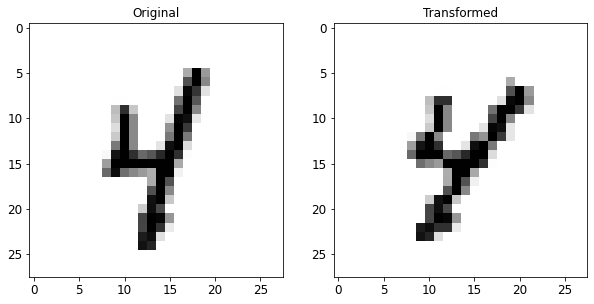

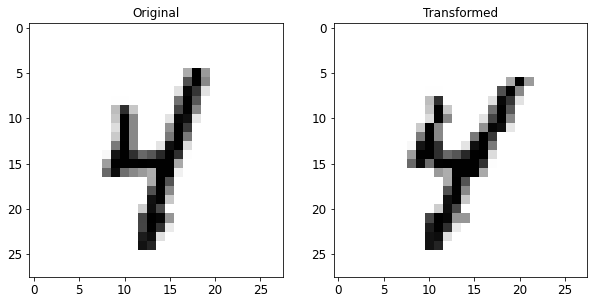

In [216]:
for i in range(3):
    rotation = math.pi * tf.random.uniform([], minval=-30, maxval=30) / 180
    random_rot = tfa.image.rotate(sample_image, rotation, fill_mode="constant")
    visualize_transformation(sample_image, random_rot)

# Data Pipeline

In [253]:
def augment(image, label, max_rot=30, max_zoom=1.2):
    rotation = math.pi * tf.random.uniform([], minval=-max_rot, maxval=max_rot) / 180
    zoom = tf.random.uniform([], minval=1, maxval=max_zoom)
    zoomed_size = int(28 / zoom)

    t_image_rotate = tfa.image.rotate(image, rotation, fill_mode="constant")
    t_image_zoom = tf.image.random_crop(t_image_rotate, size=[zoomed_size, zoomed_size, 1])
    t_image = tf.image.resize(t_image_zoom, [28, 28])
    
    final_image = tf.cast(t_image, tf.uint8)
    return final_image, label

In [254]:
batch_size = 32
train_set_augmented = train_set_raw.map(augment)
train_set = train_set_raw.concatenate(train_set_augmented).shuffle(110000).map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

## LRN

In [271]:
class LocalResponseNormalizationLayer(keras.layers.Layer):
    def __init__(self, depth_radius=5, **kwargs):
        super().__init__(**kwargs)
        self.depth_radius = depth_radius
        
    def call(self, inputs):
        return tf.nn.local_response_normalization(inputs, depth_radius=self.depth_radius)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "depth_radius": self.depth_radius}

## Re-Train

In [ ]:
reset_backend()

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    #LocalResponseNormalizationLayer(),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

run_index = 4
run_logdir = os.path.join(TENSORBOARD_DIR, "first_model_run_{:02d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=8)

lr_scheduler_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=4)

model.fit(train_set, epochs=100, 
          validation_data=valid_set,
          callbacks=[tensorboard_cb, early_stopping_cb, lr_scheduler_cb])

In [275]:
model.evaluate(test_set)

313/313 [==============================] - 5s 15ms/step - loss: 0.0396 - accuracy: 0.9872


[0.039572834968566895, 0.9872000217437744]

# Transfer Learning

## Get Dataset

In [276]:
train_set_raw, valid_set_raw, test_set_raw = tfds.load("stanford_dogs", 
    split=["train", "test[:30%]", "test[30%:]"], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteTJAAAT/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteTJAAAT/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [286]:
dataset, info = tfds.load("stanford_dogs", as_supervised=True, with_info=True)

In [292]:
class_names = info.features["label"].names
len(class_names)

120

In [446]:
n_classes = info.features["label"].num_classes
n_classes

120

Plot some images to see the size and visualize (and just to look at doggos).

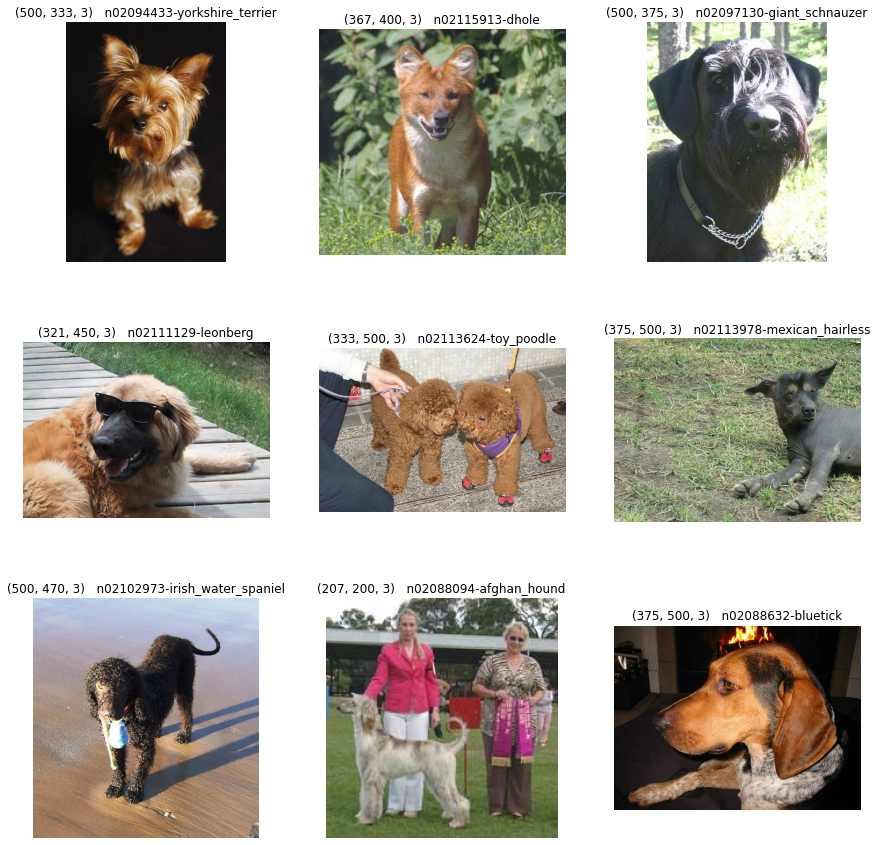

In [300]:
plt.figure(figsize=(15,15))
for index, (image, label) in enumerate(train_set_raw.take(9)):
    plt.subplot(3, 3, index+1)
    plt.imshow(image)
    plt.title("{}   {}".format(image.shape, class_names[label]))
    plt.axis("off")

Experiment with resizing the image without losing or altering information.

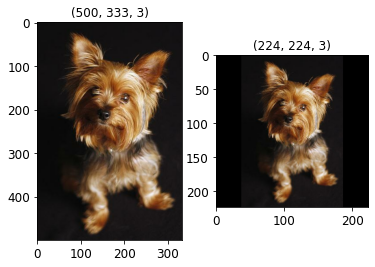

In [311]:
for image, label in train_set_raw.take(1):
    resized = tf.cast(tf.image.resize_with_pad(image, 224, 224), tf.uint8)
plt.subplot(121)
plt.title(image.shape)
plt.imshow(image)
plt.subplot(122)
plt.title(resized.shape)
plt.imshow(resized)

It seems, that resizing with pad is the best way to get the image to our desired dimensions without losing information.

Let's visualize all some images, but resized, and also apply xception's preprocessing.

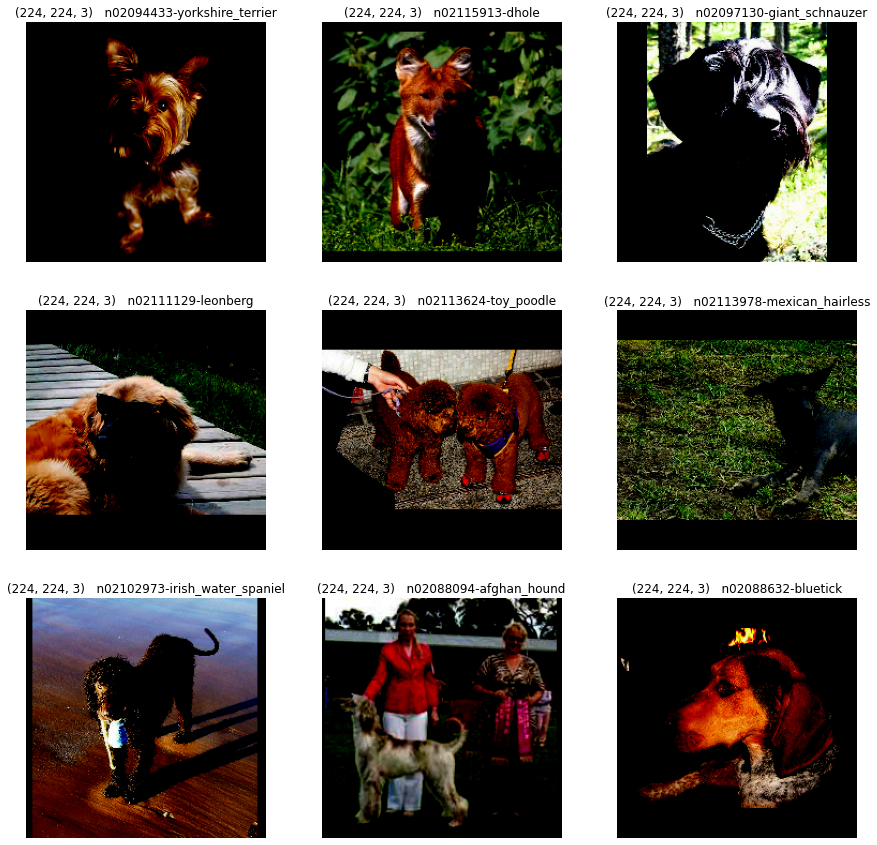

In [423]:
plt.figure(figsize=(15,15))
for index, (image, label) in enumerate(train_set_raw.take(9)):
    plt.subplot(3, 3, index+1)
    
    seed = rng.make_seeds(count=2)[0]
    transformed_img = image
    transformed_img = tf.image.resize_with_pad(
        transformed_img, 224, 224)
    final_image = keras.applications.xception.preprocess_input(transformed_img)
    
    plt.imshow(final_image)
    plt.title("{}   {}".format(resized_img.shape, class_names[label]))
    plt.axis("off")

The images above are significantly darker or higher contrast than the raw images. So our data augmentation should not darken any further or we will end up with a pure black square.

Experimenting with brightness and using the xception preprocessing.
<br>
The goal is to make sure that our augmentation steps are good augmentations (for some reason the xception model's preprocessing darkens and increases contrast of our data).

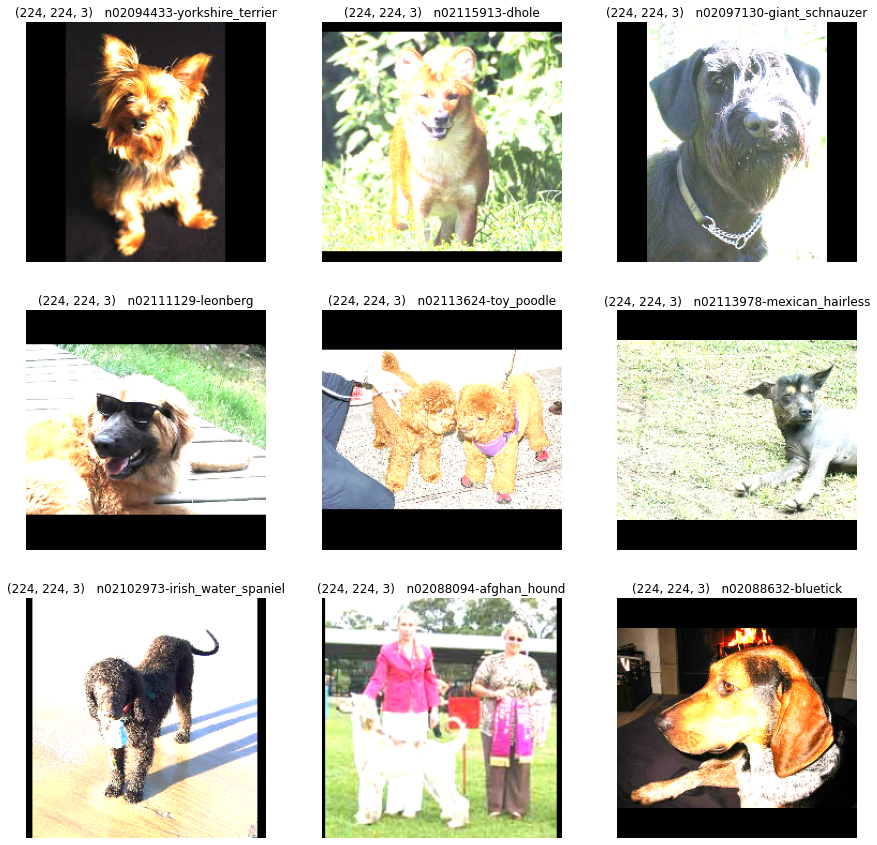

In [432]:
plt.figure(figsize=(15,15))
for index, (image, label) in enumerate(train_set_raw.take(9)):
    plt.subplot(3, 3, index+1)
    
    seed = rng.make_seeds(count=2)[0]
    transformed_img = image
    transformed_img = tf.image.adjust_brightness(transformed_img, delta=0.5)
    transformed_img = tf.image.resize_with_pad(
        transformed_img, 224, 224)
    final_image = keras.applications.xception.preprocess_input(transformed_img)
    
    plt.imshow(final_image)
    plt.title("{}   {}".format(resized_img.shape, class_names[label]))
    plt.axis("off")

This seems like a decent brightness augmentation level, not much information is lost.

We will be transfer learning with the Xception model (a model that uses separable convolutional layers - spatial first then depthwise - and also makes use of skip connections like ResNet).

## Data Input Pipeline

- Resize image to (244, 244) (height, width) with padding
- Apply Xception's preprocessing to image
- Add data augmentation
    - Randomly determine whether to augment
        - Random brightness
        - Random flip left right

In [439]:
rng = tf.random.Generator.from_seed(123, alg='philox')

Using stateless random functions, let's randomize brightness and flip the images horizontally.

In [442]:
def random_brightness(image, seed):
    rand_delta = tf.random.stateless_uniform([], seed, 
        minval=0, maxval=0.5)
    return tf.image.adjust_brightness(image, delta=rand_delta)

def preprocess(image, label, augment=False):
    if augment:
        seeds = tf.random.experimental.stateless_split(
            rng.make_seeds(count=2)[0],
            num=3)

        rand_bright_img = random_brightness(
            image, seed=seeds[0])

        image = tf.image.stateless_random_flip_left_right(
            rand_bright_img, seed=seeds[2])

    transformed_img = tf.image.resize_with_pad(
        image, 224, 224)
    final_image = keras.applications.xception.preprocess_input(transformed_img)
    return final_image, label

Use functools partial to return a function but also be able to change arguments in the function.

In [443]:
from functools import partial

batch_size = 32
train_set = train_set_raw.shuffle(12000).map(partial(preprocess, augment=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Let's try plotting some images from our input pipeline.

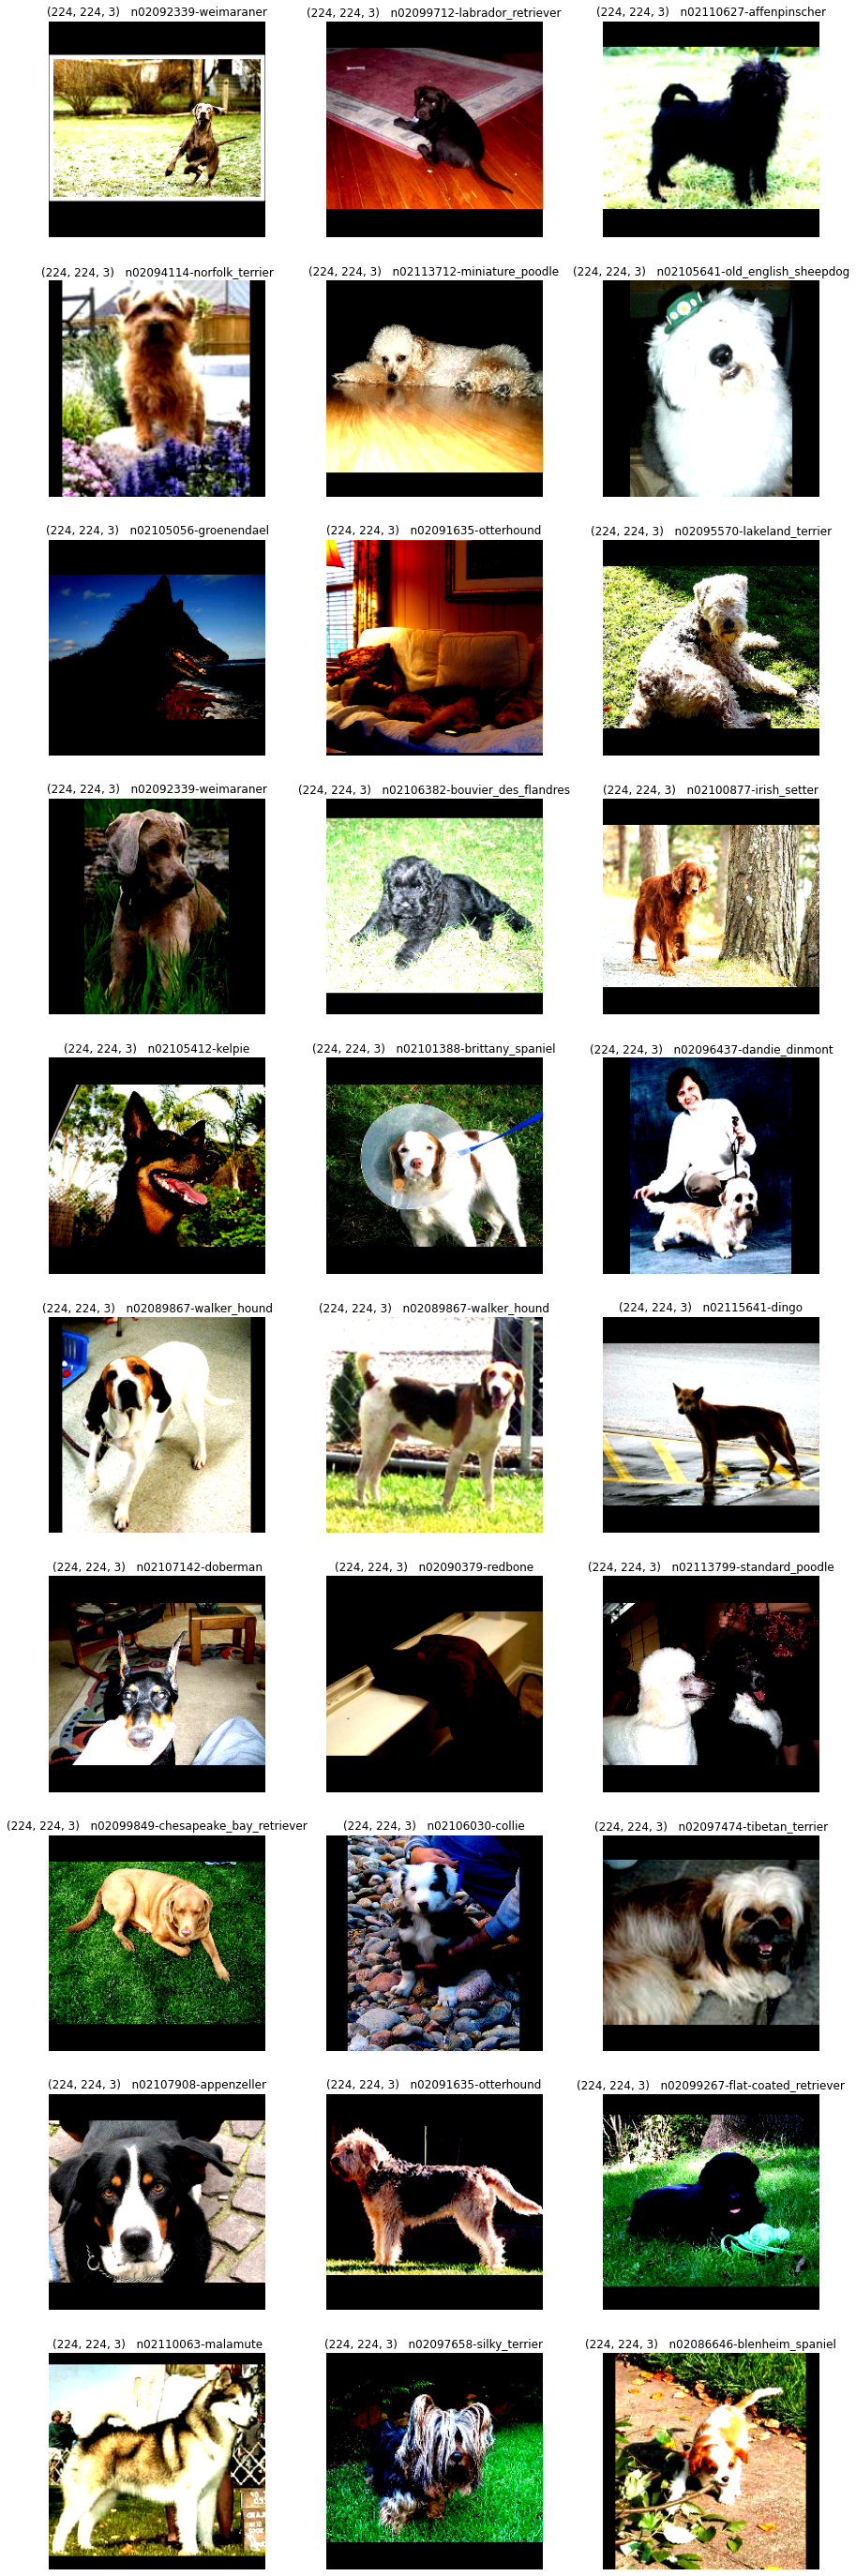

In [445]:
for image_batch, label_batch in train_set.take(1):
    plt.figure(figsize=(15,50))
    for index in range(30):
        plt.subplot(10, 3, index+1)
        plt.imshow(image_batch[index])
        plt.title("{}   {}".format(image_batch[index].shape, 
                                   class_names[label_batch[index]]))
        plt.axis("off")

Quite good, no images seem overly distorted or have any significant loss of information.

## Apply Transfer Learning

- Get the pre-trained xception model
    - Do not get the top layers
- Create your own output layers
    - Global avg pooling
    - Output 120 dog classes softmax
- Freeze pre-trained layers
    - Train with high lr for some epochs
- Un-Freeze layers
    - Train with low lr with early stopping for some epochs

In [449]:
base_model = keras.applications.xception.Xception(include_top=False, 
                                                  weights="imagenet")
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

model = keras.models.Model(inputs=base_model.input, outputs=output)

Freeze pretrained layers.

In [450]:
for layer in base_model.layers:
    layer.trainable = False

Train with high lr for some epochs.

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

run_index = 1
run_logdir = os.path.join(TENSORBOARD_DIR, "dogs_first_model_run_{:02d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

model.fit(train_set, epochs=3,
          validation_data=valid_set,
          callbacks=[tensorboard_cb])

Training is way too slow, so I will not train for now, but after training with freezed lower layers, unfreeze them and fine-tune model with a low lr.

In [ ]:
for layer in base_model.layers:
    layer.trainable=True
    
optimizer = keras.optimizers.Nadam(learning_rate=1e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

run_index = 1
run_logdir = os.path.join(TENSORBOARD_DIR, "dogs_first_model_run_{:02d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=4)

lr_scheduler_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)

model.fit(train_set, epochs=10,
          validation_data=valid_set,
          callbacks=[tensorboard_cb, early_stopping_cb, lr_scheduler_cb])